<a href="https://colab.research.google.com/github/Kryptera-K/ALGN-Falling-QQE-SMA-Breakout-Confirmation-Strategy/blob/main/ALGN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install vectorbt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 527.7/527.7 kB 16.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 315.5/315.5 kB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 36.9 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import yfinance as yf
import vectorbt as vbt

# -------------------------
# Download Data
# -------------------------

symbol = "ALGN"
start_date = "2000-01-01"
end_date = "2026-01-01"
interval = "1d"

df = yf.download(symbol, start=start_date, end=end_date, interval=interval, multi_level_index=False)
df.to_csv("ALGN_clean.csv", index=False)
df

/tmp/ipython-input-3821725459.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(symbol, start=start_date, end=end_date, interval=interval, multi_level_index=False)
[*********************100%***********************]  1 of 1 completed


,Close,High,Low,Open,Volume
Date,,,,,
2001-01-30,16.875000,18.187500,16.250000,18.125000,812300
2001-01-31,13.500000,17.187500,13.437500,17.125000,1212700
2001-02-01,14.187500,14.375000,13.000000,13.125000,669100
2001-02-02,14.125000,14.562500,13.750000,14.000000,775000
2001-02-05,14.125000,14.500000,13.875000,14.437500,489400
...,...,...,...,...,...
2025-11-12,141.690002,145.250000,140.690002,144.449997,1212800
2025-11-13,139.419998,143.419998,138.929993,140.320007,1026800
2025-11-14,137.130005,138.020004,136.000000,137.009995,809700


In [ ]:
# -------------------------
# Necessary Parameters
# -------------------------

KC_MULTIPLIER = 2
KC_PERIOD = 20
KC_SHIFT = 5
QQE_FACTOR = 4.236
QQE_LEVEL = 50
QQE_PERIOD = 14
QQE_SHIFT = 5
QQE_SMOOTH = 5
WMA_PERIOD = 20
WMA_SHIFT = 5
SMA_PERIOD = 20

# -------------------------
# Indicator Functions
# -------------------------

def qqe_value2_falling(df, shift=QQE_SHIFT):
    df = calculate_qqe(df)
    return df['QQE_Value2'] < df['QQE_Value2'].shift(shift)


def calculate_qqe(df, rsi_period=QQE_PERIOD, smooth=QQE_SMOOTH, factor=QQE_FACTOR):
    """
    Calculate QQE lines (Value1 & Value2) based on RSI smoothing and ATR-like smoothing.
    """
    df = df.copy()

    # --- RSI ---
    delta = df['Close'].diff()
    up = delta.clip(lower=0)
    down = -delta.clip(upper=0)
    roll_up = up.ewm(alpha=1/rsi_period, adjust=False).mean()
    roll_down = down.ewm(alpha=1/rsi_period, adjust=False).mean()
    rsi = 100 - (100 / (1 + roll_up / roll_down))

    # --- Smoothed RSI ---
    rsi_ma = rsi.rolling(window=smooth).mean().fillna(method='bfill')

    # --- RSI Delta & ATR-like smoothing ---
    rsi_delta = rsi_ma.diff().abs().fillna(0)
    atr_rsi = rsi_delta.ewm(alpha=1/smooth, adjust=False).mean()

    # --- QQE Calculation ---
    value1 = rsi_ma.copy()
    value2 = pd.Series(index=df.index, dtype=float)
    value2.iloc[0] = value1.iloc[0]

    for i in range(1, len(df)):
        prev_trail = value2.iloc[i-1]
        prev_value1 = value1.iloc[i-1]
        atr = atr_rsi.iloc[i]
        direction = 1 if prev_value1 > prev_trail else -1
        value2.iloc[i] = prev_trail + direction * factor * atr

    df['QQE_Value1'] = value1
    df['QQE_Value2'] = value2

    return df


def close_above_sma(df, period=SMA_PERIOD):
    df = calculate_sma(df, period)
    return df['Close'] > df['SMA']


def calculate_sma(df, period=SMA_PERIOD):
    """
    Calculate Simple Moving Average (SMA) of the Close price.
    """
    df = df.copy()
    df['SMA'] = df['Close'].rolling(window=period).mean()
    return df


def kc_lower_band_falling(df, shift=KC_SHIFT):
    df = calculate_keltner_channel(df)
    return df['KC_Lower'] < df['KC_Lower'].shift(shift)


def calculate_keltner_channel(df, period=KC_PERIOD, multiplier=KC_MULTIPLIER):
    """
    Calculate Keltner Channel (Mid, Upper, Lower) and ATR.
    """
    df = df.copy()

    # Typical Price
    df['TP'] = (df['High'] + df['Low'] + df['Close']) / 3

    # EMA of Typical Price
    df['KC_Mid'] = df['TP'].ewm(span=period, adjust=False).mean()

    # True Range and ATR
    df['H-L'] = df['High'] - df['Low']
    df['H-PC'] = abs(df['High'] - df['Close'].shift(1))
    df['L-PC'] = abs(df['Low'] - df['Close'].shift(1))
    df['TR'] = df[['H-L','H-PC','L-PC']].max(axis=1)
    df['ATR'] = df['TR'].rolling(period).mean()

    # Upper and Lower Bands
    df['KC_Upper'] = df['KC_Mid'] + multiplier * df['ATR']
    df['KC_Lower'] = df['KC_Mid'] - multiplier * df['ATR']

    return df


def close_above_wma(df, period=WMA_PERIOD):
    df = calculate_wma(df, period)
    return df['Close'] > df['WMA']


def calculate_wma(df, period=WMA_PERIOD):
    """
    Calculate Weighted Moving Average (WMA) for the Close price
    and add it as a column to the DataFrame.
    """
    df = df.copy()
    weights = np.arange(1, period + 1)
    df['WMA'] = df['Close'].rolling(period).apply(lambda prices: np.dot(prices, weights) / weights.sum(), raw=True)
    return df



# -------------------------
# Entry conditions
# -------------------------

df["QQE_Value2_Falling"] = qqe_value2_falling(df)
df["Close_Above_SMA"] = close_above_sma(df)

# -------------------------
# Exit conditions
# -------------------------

df["KC_Lower_Band_Falling"] = kc_lower_band_falling(df)
df["WMA_Close_Above"] = close_above_wma(df)

# -------------------------
# Signals
# -------------------------

entry_conditions = [
    'QQE_Value2_Falling',
    'Close_Above_SMA',
]
exit_conditions = [
    'KC_Lower_Band_Falling',
    'WMA_Close_Above',
]

df['entry_signal'] = df[entry_conditions].all(axis=1)
df['exit_signal']  = df[exit_conditions].all(axis=1)

# -------------------------
# Backtest
# -------------------------


shift_entries = df['entry_signal'].shift(1).astype(bool).fillna(False).to_numpy()
shift_exits = df['exit_signal'].shift(1).astype(bool).fillna(False).to_numpy()

pf = vbt.Portfolio.from_signals(
    close=df['Open'],
    entries=shift_entries,
    exits=shift_exits,
    init_cash=100_000,
    fees=0.001,
    slippage=0.002,
    freq='1d'
)

# -------------------------
# Portfolio Stats / Plot
# -------------------------

print(pf.stats())
pf.plot().show()

/tmp/ipython-input-3288144318.py:41: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  rsi_ma = rsi.rolling(window=smooth).mean().fillna(method='bfill')


Start                                2001-01-30 00:00:00
End                                  2025-11-18 00:00:00
Period                                6239 days 00:00:00
Start Value                                     100000.0
End Value                                  2448008.87003
Total Return [%]                              2348.00887
Benchmark Return [%]                          630.868972
Max Gross Exposure [%]                             100.0
Total Fees Paid                            198501.534101
Max Drawdown [%]                               83.886399
Max Drawdown Duration                 2432 days 00:00:00
Total Trades                                         103
Total Closed Trades                                  102
Total Open Trades                                      1
Open Trade PnL                            -134315.146762
Win Rate [%]                                   49.019608
Best Trade [%]                                162.896927
Worst Trade [%]                

In [ ]:
# Buy and Hold Performance Metrics
df_holding = df['Open']
pf_holding = vbt.Portfolio.from_holding(df_holding, init_cash=100_000 , freq='D')
print(pf_holding.stats())

Start                         2001-01-30 00:00:00
End                           2025-11-18 00:00:00
Period                         6239 days 00:00:00
Start Value                              100000.0
End Value                           730868.972252
Total Return [%]                       630.868972
Benchmark Return [%]                   630.868972
Max Gross Exposure [%]                      100.0
Total Fees Paid                               0.0
Max Drawdown [%]                        92.662069
Max Drawdown Duration          1196 days 00:00:00
Total Trades                                    1
Total Closed Trades                             0
Total Open Trades                               1
Open Trade PnL                      630868.972252
Win Rate [%]                                  NaN
Best Trade [%]                                NaN
Worst Trade [%]                               NaN
Avg Winning Trade [%]                         NaN
Avg Losing Trade [%]                          NaN


/tmp/ipython-input-3030866533.py:14: FutureWarning:

YF.download() has changed argument auto_adjust default to True

[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-3030866533.py:72: FutureWarning:

Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.



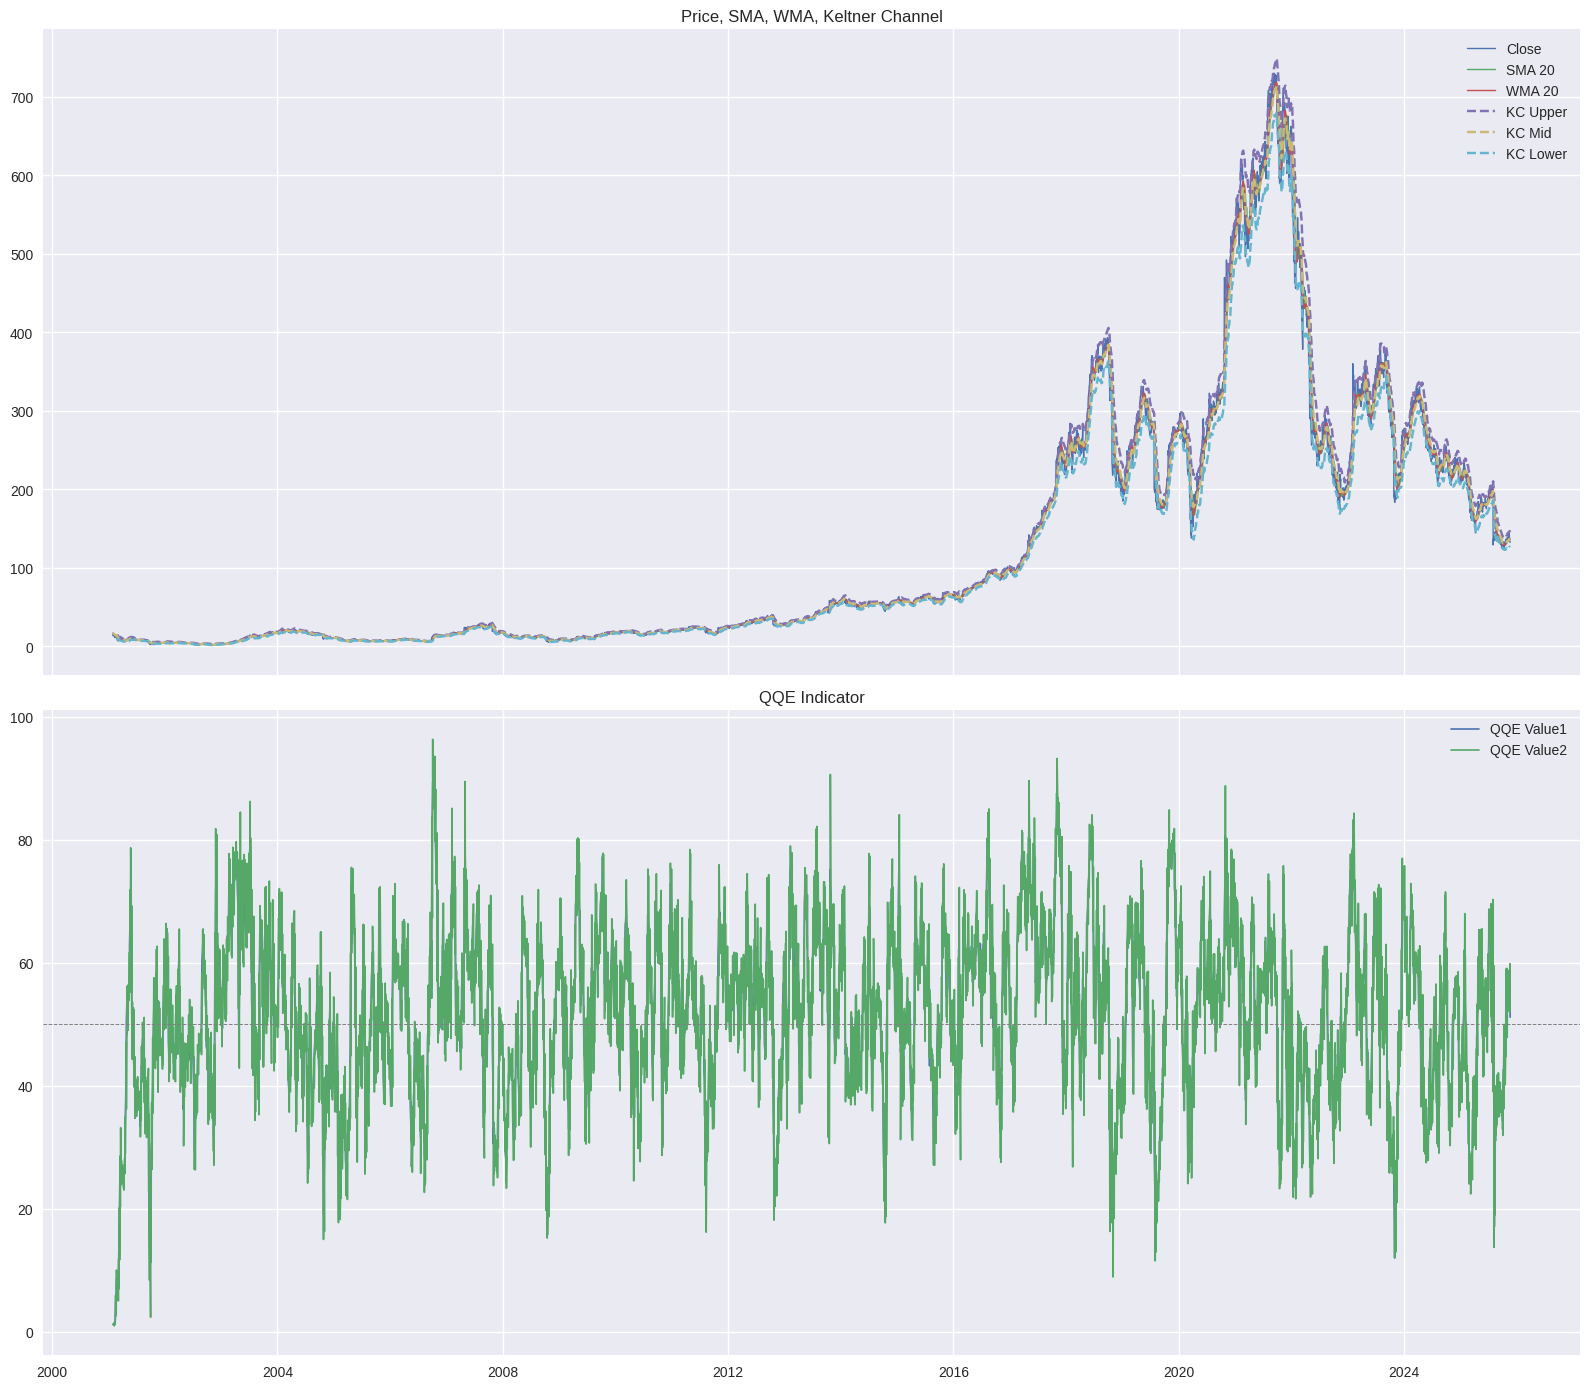

In [ ]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt

# ------------------------------------------------
# Download Data
# ------------------------------------------------
symbol = "ALGN"
start_date = "2000-01-01"
end_date = "2026-01-01"
interval = "1d"

df = yf.download(symbol, start=start_date, end=end_date, interval=interval, multi_level_index=False)

# ------------------------------------------------
# Indicator Parameters
# ------------------------------------------------
KC_MULTIPLIER = 2
KC_PERIOD = 20
KC_SHIFT = 5
QQE_FACTOR = 4.236
QQE_LEVEL = 50
QQE_PERIOD = 14
QQE_SHIFT = 5
QQE_SMOOTH = 5
WMA_PERIOD = 20
WMA_SHIFT = 5
SMA_PERIOD = 20

# ------------------------------------------------
# Indicator Functions
# ------------------------------------------------

def calculate_sma(df, period=SMA_PERIOD):
    df['SMA'] = df['Close'].rolling(window=period).mean()
    return df

def calculate_wma(df, period=WMA_PERIOD):
    df = df.copy()
    weights = np.arange(1, period + 1)
    df['WMA'] = df['Close'].rolling(period).apply(lambda prices: np.dot(prices, weights) / weights.sum(), raw=True)
    return df

def calculate_keltner_channel(df, period=KC_PERIOD, multiplier=KC_MULTIPLIER):
    df = df.copy()

    df['TP'] = (df['High'] + df['Low'] + df['Close']) / 3
    df['KC_Mid'] = df['TP'].ewm(span=period, adjust=False).mean()

    df['H-L'] = df['High'] - df['Low']
    df['H-PC'] = abs(df['High'] - df['Close'].shift(1))
    df['L-PC'] = abs(df['Low'] - df['Close'].shift(1))
    df['TR'] = df[['H-L','H-PC','L-PC']].max(axis=1)
    df['ATR'] = df['TR'].rolling(period).mean()

    df['KC_Upper'] = df['KC_Mid'] + multiplier * df['ATR']
    df['KC_Lower'] = df['KC_Mid'] - multiplier * df['ATR']
    return df

def calculate_qqe(df, rsi_period=QQE_PERIOD, smooth=QQE_SMOOTH, factor=QQE_FACTOR):
    df = df.copy()

    delta = df['Close'].diff()
    up = delta.clip(lower=0)
    down = -delta.clip(upper=0)

    roll_up = up.ewm(alpha=1/rsi_period, adjust=False).mean()
    roll_down = down.ewm(alpha=1/rsi_period, adjust=False).mean()
    rsi = 100 - (100 / (1 + roll_up / roll_down))

    rsi_ma = rsi.rolling(window=smooth).mean().fillna(method='bfill')

    rsi_delta = rsi_ma.diff().abs().fillna(0)
    atr_rsi = rsi_delta.ewm(alpha=1/smooth, adjust=False).mean()

    value1 = rsi_ma.copy()
    value2 = pd.Series(index=df.index, dtype=float)
    value2.iloc[0] = value1.iloc[0]

    for i in range(1, len(df)):
        prev_trail = value2.iloc[i-1]
        prev_value1 = value1.iloc[i-1]
        atr = atr_rsi.iloc[i]
        direction = 1 if prev_value1 > prev_trail else -1
        value2.iloc[i] = prev_trail + direction * factor * atr

    df['QQE_Value1'] = value1
    df['QQE_Value2'] = value2

    return df

# ------------------------------------------------
# Apply Indicators
# ------------------------------------------------

df = calculate_sma(df)
df = calculate_wma(df)
df = calculate_keltner_channel(df)
df = calculate_qqe(df)

# ------------------------------------------------
# Plot All Indicators
# ------------------------------------------------
plt.style.use("seaborn-v0_8")

fig, axs = plt.subplots(2, 1, figsize=(16, 14), sharex=True)

# ---------------------------- PRICE + MA + KC ----------------------------
axs[0].plot(df.index, df['Close'], label="Close", linewidth=1)
axs[0].plot(df.index, df['SMA'], label=f"SMA {SMA_PERIOD}", linewidth=1)
axs[0].plot(df.index, df['WMA'], label=f"WMA {WMA_PERIOD}", linewidth=1)

axs[0].plot(df.index, df['KC_Upper'], label="KC Upper", linestyle="--")
axs[0].plot(df.index, df['KC_Mid'], label="KC Mid", linestyle="--")
axs[0].plot(df.index, df['KC_Lower'], label="KC Lower", linestyle="--")

axs[0].set_title("Price, SMA, WMA, Keltner Channel")
axs[0].legend()

# ---------------------------- QQE ----------------------------
axs[1].plot(df.index, df['QQE_Value1'], label="QQE Value1", linewidth=1.2)
axs[1].plot(df.index, df['QQE_Value2'], label="QQE Value2", linewidth=1.2)
axs[1].axhline(50, color="gray", linestyle="--", linewidth=0.7)

axs[1].set_title("QQE Indicator")
axs[1].legend()

plt.tight_layout()
plt.show()
